## This notebook can be used to rank a list of nodes from a category that connect to an entity such as a gene. 
#### Example 1: Which disease are associate with NPM1 gene?
#### Example 2: Which proteins interacts with protein NPM1?
#### Example 3: Which drugs or small molecules can interact with NPM1?


In [1]:
import sys
sys.path.append('../src')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
import requests
def query_name_resolver_reverse(query_json):
    response = requests.post("https://name-lookup.ci.transltr.io/reverse_lookup", json=query_json)
    result = {}
    if response.status_code == 200:
        result = response.json()
    return(result)

def ID_convert_to_preferred_name_nodeNormalizer(id_list):
    id_list_original = id_list
    dic_id_map = {}
    
    
    if len(id_list_original) <= 900:
        query_json = {"curies":id_list_original}
        result = query_name_resolver_reverse(query_json)

        for id in id_list_original:
            if id in result:
                if "preferred_name" in result[id]:
                    dic_id_map[id] = result[id]["preferred_name"]
                else:
                    print(id + "no preferred name")
                    dic_id_map[id] = id
            else:
                print(id + "not in the result")
                dic_id_map[id] = id
                    
    else:
        dic_batch_id = {}
        batch = 0
        id_list_cur = id_list
        while len(id_list_cur)> 900:
            
            # split the list into list smaller than 900
            dic_batch_id[batch] = id_list_cur[0:900]
            id_list_cur = id_list_cur[900:]
            batch = batch + 1

        dic_batch_id[batch] = id_list_cur
        
        
        for batch in dic_batch_id:
            query_json = {"curies":dic_batch_id[batch]}
            result = query_name_resolver_reverse(query_json)

            for id in dic_batch_id[batch]:
                if id in result:
                    if "preferred_name" in result[id]:
                        dic_id_map[id] = result[id]["preferred_name"]
                    else:
                        print(id+":no preferred name")
                        dic_id_map[id] = id
                else:
                    print(id+"not in the result")
                    dic_id_map[id] = id
    return(dic_id_map)

def visulization_one_hop_ranking(result_ranked_by_primary_infores,result_parsed , num_of_nodes = 50, input_query = "NCBIGene:3845"):
    # edited Dec 5, 2023
    predicates_list = []
    primary_infore_list = []
    aggregator_infore_list = []


    for i in range(0, result_ranked_by_primary_infores.shape[0]):
        oupput_node = result_ranked_by_primary_infores['output_node'][i]
        type_of_node = result_ranked_by_primary_infores['type_of_nodes'][i]
        if type_of_node == 'object':
            subject = input_query
            object = oupput_node
        else:
            subject = oupput_node
            object = input_query
            
        predicates_list = predicates_list + result_parsed[subject + "_" + object]['predicate']
        primary_infore_list = primary_infore_list + result_parsed[subject + "_" + object]['primary_knowledge_source']
        
        if 'aggregator_knowledge_source' in result_parsed[subject + "_" + object]:
            aggregator_infore_list = aggregator_infore_list + result_parsed[subject + "_" + object]['aggregator_knowledge_source']
            aggregator_infore_list = list(set(aggregator_infore_list))

        predicates_list = list(set(predicates_list))
        primary_infore_list = list(set(primary_infore_list))
        

    predicates_by_nodes = {}
    for predict in predicates_list:
        predicates_by_nodes[predict] = []

    primary_infore_by_nodes = {}
    for predict in primary_infore_list:
        primary_infore_by_nodes[predict] = []

    aggregator_infore_by_nodes = {}
    for predict in aggregator_infore_list:
        aggregator_infore_by_nodes[predict] = []
        
    names = []
    for i in range(0, result_ranked_by_primary_infores.shape[0]):
    #for i in range(0, 10):
        oupput_node = result_ranked_by_primary_infores['output_node'].values[i]
        names.append(oupput_node)
        type_of_node = result_ranked_by_primary_infores['type_of_nodes'].values[i]
        if type_of_node == 'object':
            subject = input_query
            object = oupput_node
        else:
            subject = oupput_node
            object = input_query
        new_id = subject + "_" + object

        cur_primary_infore = result_parsed[new_id]['primary_knowledge_source']
        for predict in primary_infore_list:
            if predict in cur_primary_infore:
                primary_infore_by_nodes[predict].append(1)
            else:
                primary_infore_by_nodes[predict].append(0)



        cur_predicates = result_parsed[new_id]['predicate']
        for predict in predicates_list:
            if predict in cur_predicates:
                predicates_by_nodes[predict].append(1)
            else:
                predicates_by_nodes[predict].append(0)

    #convert = False

    #for item in colnames:
    #    if 'NCBIGene' in item:
    #        convert = True
    #if convert:
        #Gene_id_map = Gene_id_converter(colnames, "http://127.0.0.1:8000/query_name_by_id") # option 1
        #Gene_id_map = Generate_Gene_id_map() # option 2

    dic_id_map = ID_convert_to_preferred_name_nodeNormalizer(names)
    new_colnames = []
    for item in names:
        if item in dic_id_map:
            new_colnames.append(dic_id_map[item])
        else:
            new_colnames.append(item)    

    #else:
    #    new_colnames = colnames
            
    primary_infore_by_nodes_df = pd.DataFrame(primary_infore_by_nodes)
    primary_infore_by_nodes_df.index = new_colnames
    primary_infore_by_nodes_df = primary_infore_by_nodes_df.T


    predicates_by_nodes_df = pd.DataFrame(predicates_by_nodes)
    predicates_by_nodes_df.index = new_colnames
    predicates_by_nodes_df = predicates_by_nodes_df.T

    title = "Ranking of one-hop nodes by primary infores"
    ylab = "infores"
    df = primary_infore_by_nodes_df.iloc[:,0:num_of_nodes]
    plt.figure( figsize=(0.8+df.shape[1]*0.2,3.5),dpi = 300)
        #p1 = sns.heatmap(df, cmap="Blues")
        # heatmap without color bar
    p1 = sns.heatmap(df, cmap="Blues", cbar=False)
    p1.set_title(title)
    p1.set_ylabel(ylab)
        # set title font size
    p1.title.set_size(12)

    title = "Ranking of one-hop nodes by predicate"
    ylab = "Predicate"
    df = predicates_by_nodes_df.iloc[:,0:num_of_nodes]
    plt.figure( figsize=(0.8+df.shape[1]*0.2,3.5),dpi = 300)
        #p1 = sns.heatmap(df, cmap="Blues")
        # heatmap without color bar
    p1 = sns.heatmap(df, cmap="Blues", cbar=False)
    p1.set_title(title)
    p1.set_ylabel(ylab)
        # set title font size
    p1.title.set_size(12)


    return(p1)

In [5]:
# Step1: List all the APIs in the translator system
APInames = TCT.list_Translator_APIs()
print(len(APInames))


65


In [6]:
# Step 2: Get metaKG and all predicates from Translator APIs
#metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs
#print(metaKG.columns)
#print(metaKG.shape)

#metaKG.to_csv('../metaData/metaKG.csv', index=False)
metaKG = pd.read_csv('../metaData/metaKG.csv')
All_predicates = list(set(metaKG['KG_category']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))

In [7]:
# Step 3: set input parameters
# Test multiomics BigGIM Drug Response KP
# Node1 for query
input_node1 = 'NPM1'
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
#input_node2_category = ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']
input_node2_category = ['biolink:Gene']

# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))
print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

NCBIGene:4869
all relevant predicates in Translator:
['biolink:coexists_with', 'biolink:physically_interacts_with', 'biolink:coexpressed_with', 'biolink:derives_into', 'biolink:subclass_of', 'biolink:has_phenotype', 'biolink:negatively_correlated_with', 'biolink:genetic_association', 'biolink:regulates', 'biolink:genetically_interacts_with', 'biolink:regulated_by', 'biolink:affects', 'biolink:close_match', 'biolink:causes', 'biolink:produced_by', 'biolink:biomarker_for', 'biolink:affected_by', 'biolink:binds', 'biolink:genetically_associated_with', 'biolink:related_to', 'biolink:correlated_with', 'biolink:positively_correlated_with', 'biolink:orthologous_to', 'biolink:has_input', 'biolink:derives_from', 'biolink:homologous_to', 'biolink:interacts_with', 'biolink:directly_physically_interacts_with', 'biolink:produces', 'biolink:contributes_to', 'biolink:part_of', 'biolink:has_part']
all relevant APIs in Translator:
['Automat-ubergraph-nonredundant(Trapi v1.4.0)', 'Automat-gwas-catalog(T

In [8]:
# Step 4: Format query json
query_json = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates

# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs,query_json=query_json, max_workers=len(API_URLs))

# Step 6: Parse results
result_parsed = TCT.parse_KG(result)

# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"


Warning Code:404:https://api.bte.ncats.io/v1/bde72db681ec0b8f9eeb67bb6b8dd72c/query
Warning Code:404:https://automat.renci.org/biolink/1.4/query
Success!https://automat.renci.org/hgnc/1.4/query
Success!https://automat.renci.org/panther/1.4/query
Success!https://automat.renci.org/gtex/1.4/querySuccess!https://automat.renci.org/pharos/1.4/querySuccess!https://automat.renci.org/gtopdb/1.4/query
Success!https://automat.renci.org/hmdb/1.4/query

Warning Code:404:https://automat.ci.transltr.io/sri-reference-kp/1.4/query

Warning Code:400:https://translator.broadinstitute.org/molepro/trapi/v1.4/asyncquerySuccess!https://automat.renci.org/gwas-catalog/1.4/query

Warning Code:404:https://automat.ci.transltr.io/ubergraph-nonredundant/1.4/query
Warning Code:400:https://ars-prod.transltr.io/ara-robokop/api/runquery
Success!https://automat.transltr.io/genome-alliance/1.4/querySuccess!https://automat.ci.transltr.io/ubergraph/1.4/query

Success!https://automat.ci.transltr.io/cam-kp/1.4/query?limit=10

NCBIGene:6052:no preferred name


<AxesSubplot:title={'center':'Ranking of one-hop nodes by predicate'}, ylabel='Predicate'>

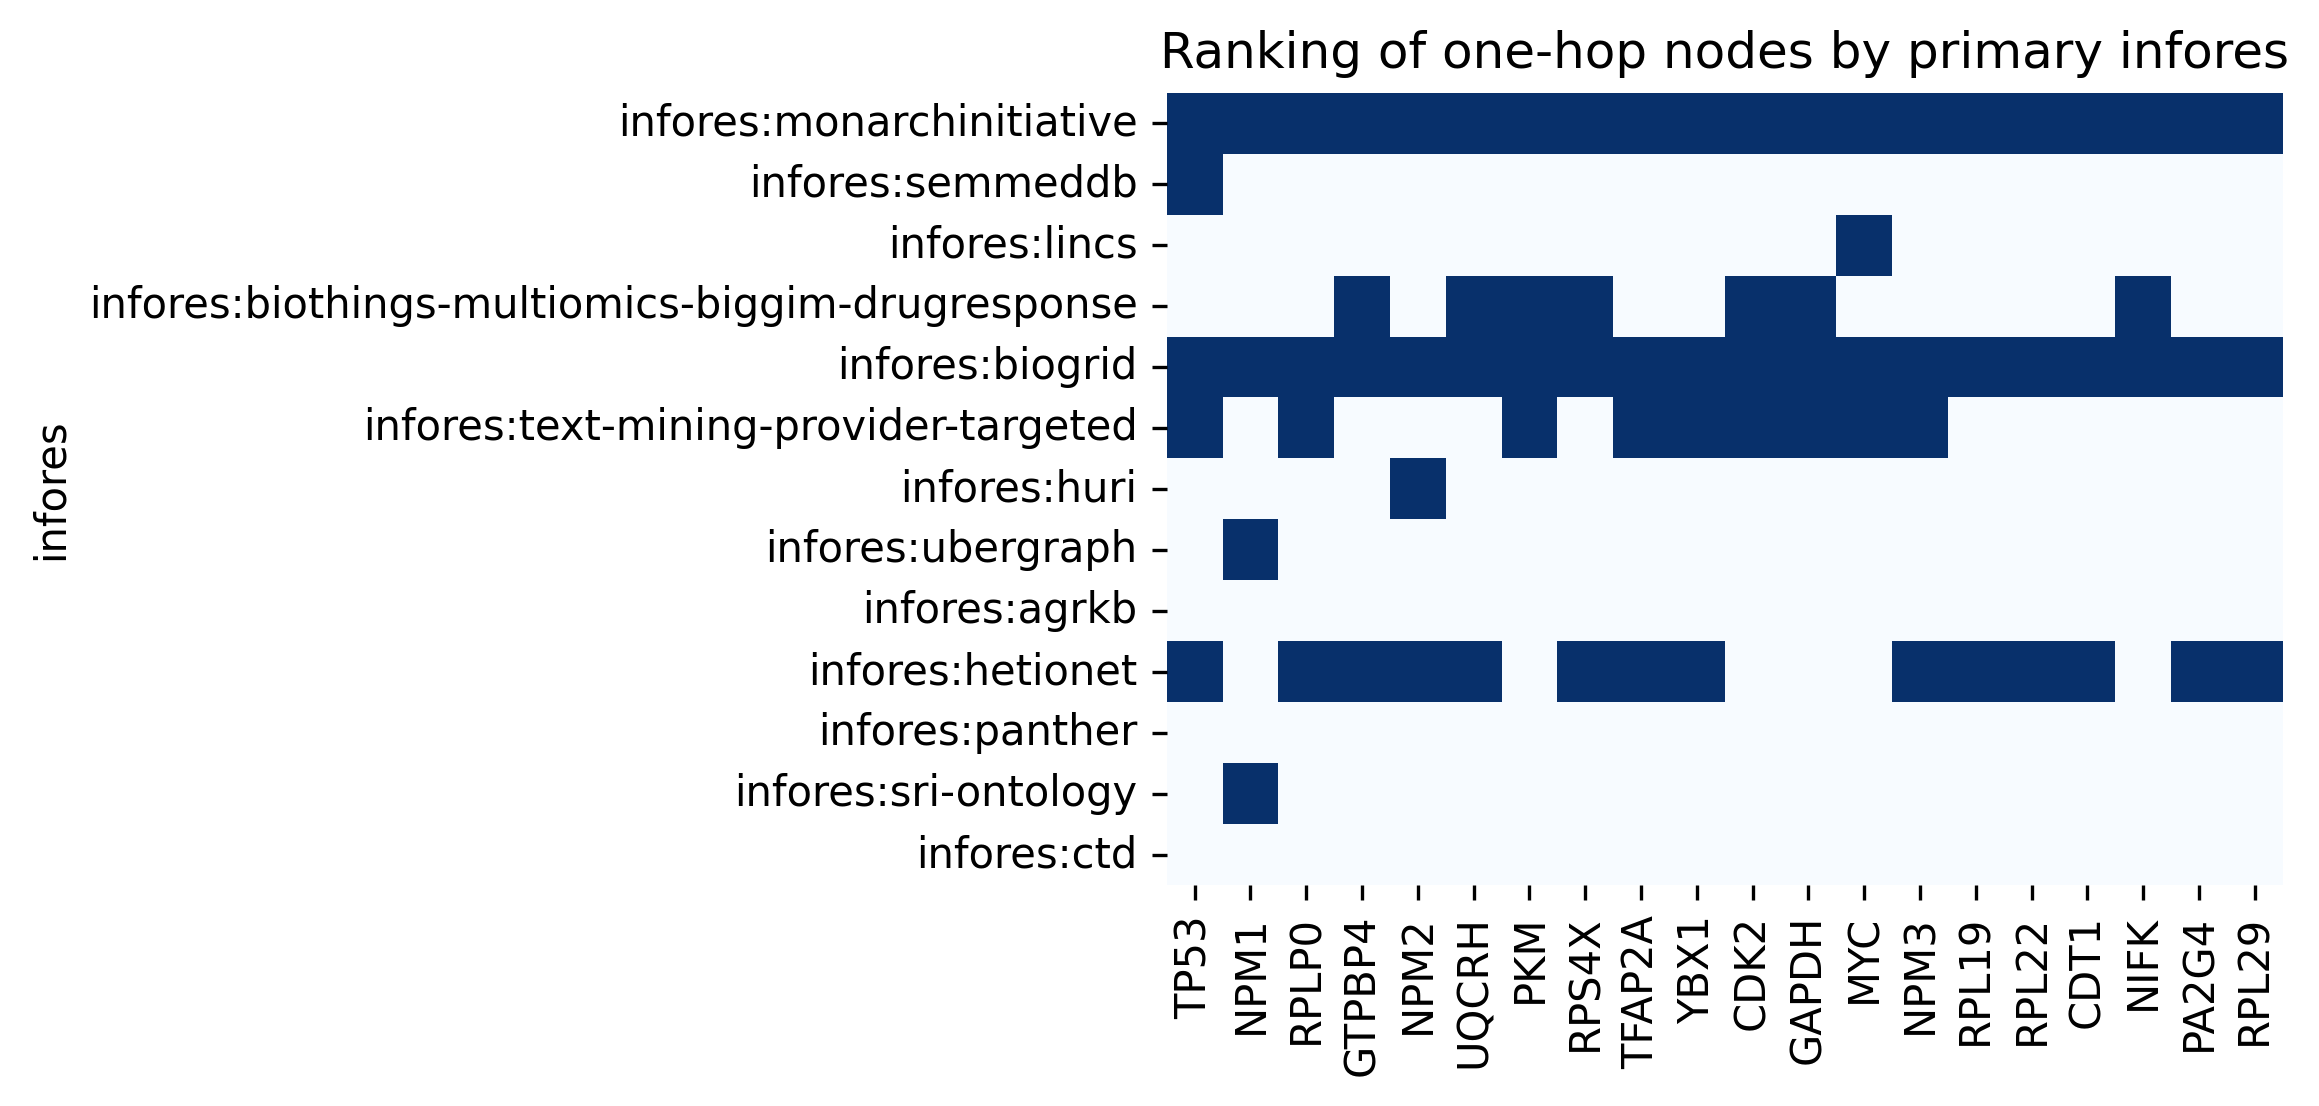

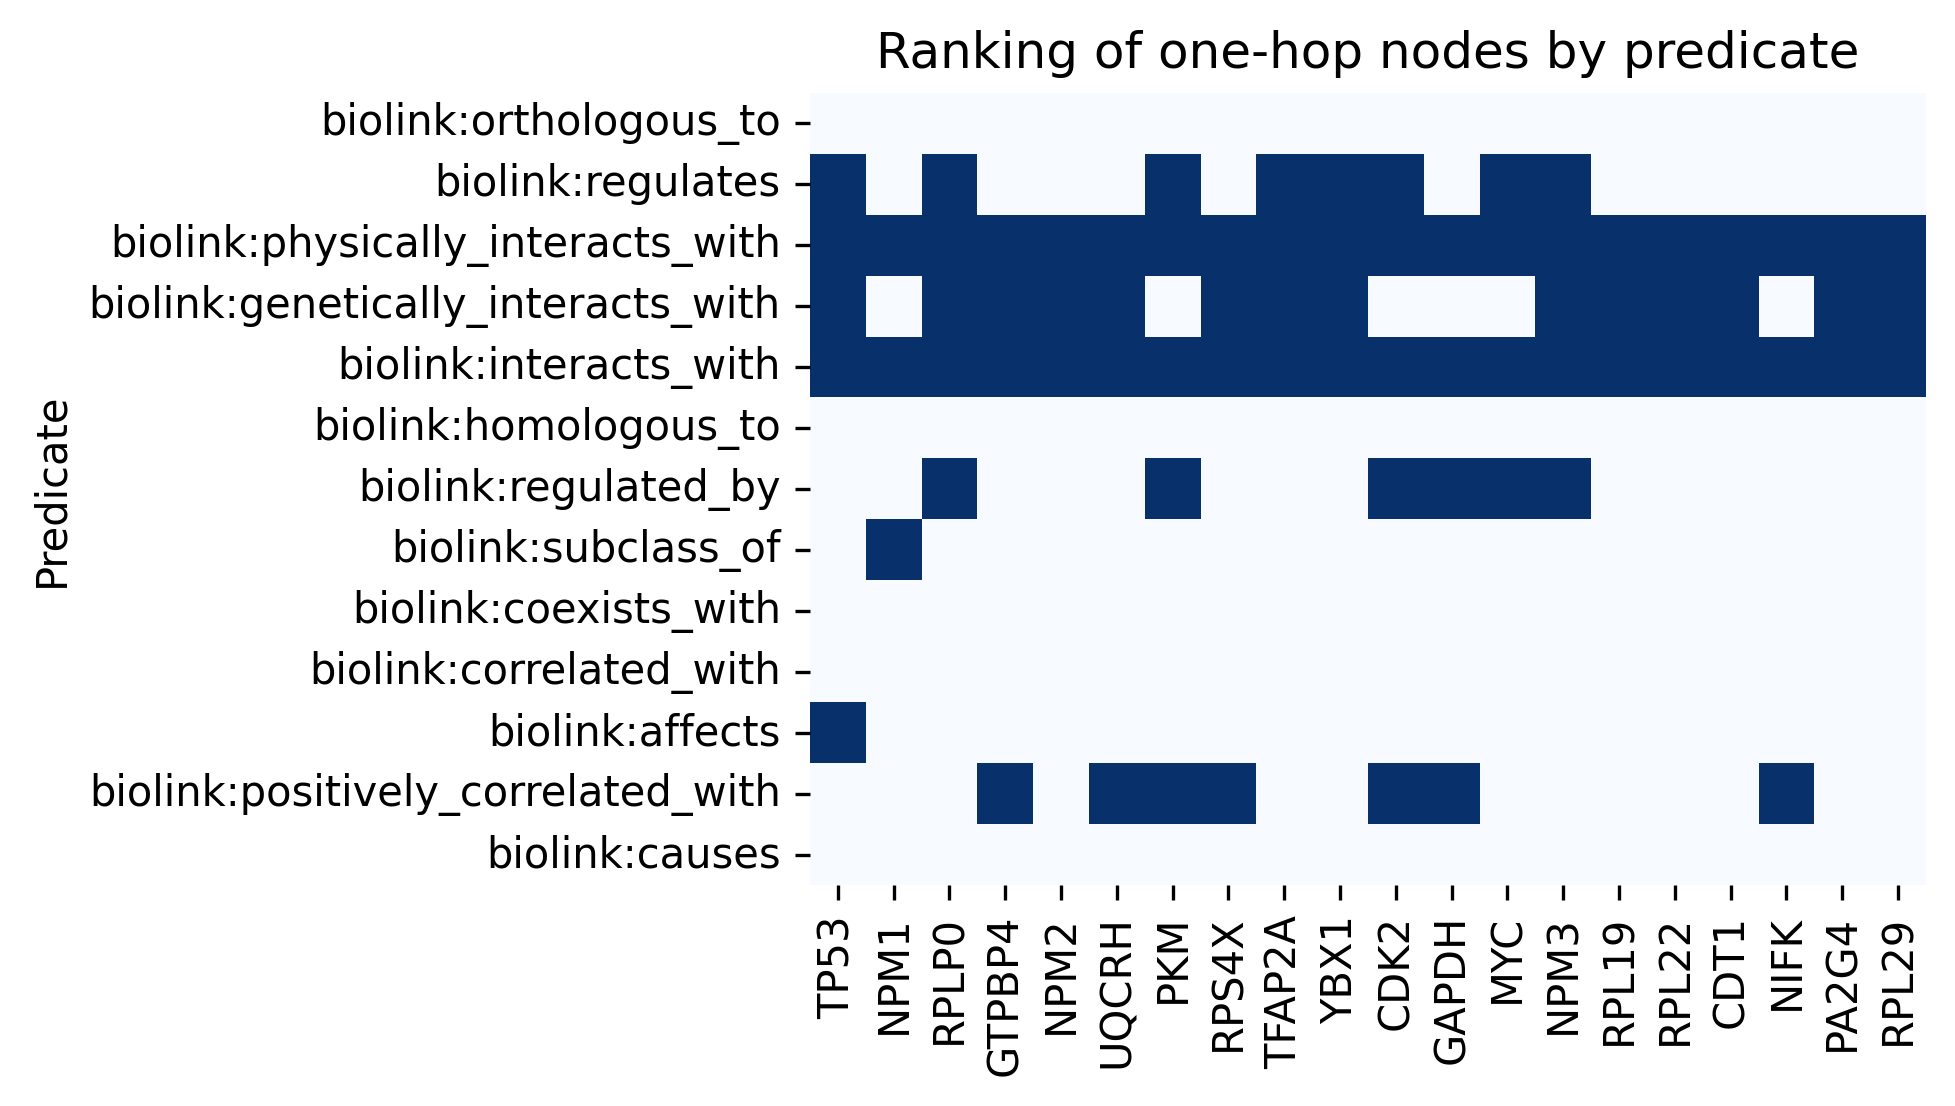

In [9]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, num_of_nodes = 20, input_query = input_node1_id)


In [6]:
# End of the example